In [1]:
import numpy
%matplotlib inline
from matplotlib import pyplot

In [2]:
import sys
sys.path.append('../scripts/')

# Our helper
from plot_helper import *

In the previous notebook, we visually explained what are eigenvectors and eigenvalues, and we can use `numpy.linalg.eig` to solve for the eigenpairs. Take $\,A = \begin{bmatrix} 1 & 0 \\ 1 & 3 \end{bmatrix}$ as an example.

In [3]:
A = numpy.array([[1,0], [1,3]])
D, C = numpy.linalg.eig(A)
print(C)

[[ 0.          0.89442719]
 [ 1.         -0.4472136 ]]


$D$ is an array of eigenvalues and each column of $C$ represents a normalized eigenvector of matrix $A$. Let us draw both eigenvectors along with this linear transformation.

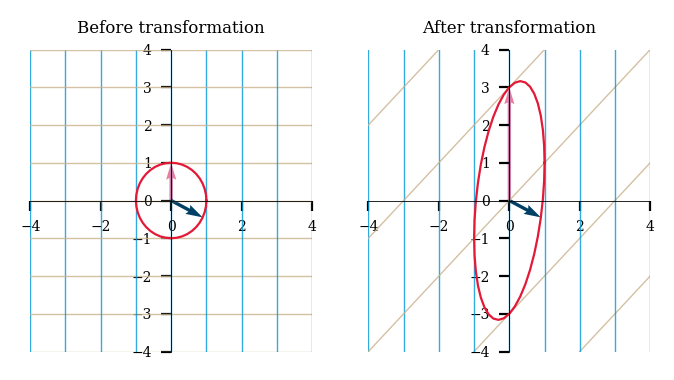

In [4]:
plot_linear_transformation(A, C[:,0], C[:,1], unit_vector=False, unit_circle=True)

We observed that the eigenvectors of a matrix $A$ will not change their directions after the transformation, therefore, they are considered very special to $A$. Besides, since the matrix $A$ transforms a unit circle into an ellipse, there is another interesting pair of vectors -  the vectors on the major and minor axis of this ellipse. They are intriguing because they are most stretched and most shrunk vectors after the transformation. Let us find them first.

In [5]:
alpha = numpy.linspace(0, 2*numpy.pi, 201)
circle = numpy.vstack((numpy.cos(alpha), numpy.sin(alpha)))
ellipse = A @ circle    # 2 by 41 ndarray
distance = numpy.linalg.norm(ellipse, axis=0)
major_id = numpy.argmax(distance)
minor_id = numpy.argmin(distance)
major = ellipse[:, major_id]
minor = ellipse[:, minor_id]
print(major, numpy.linalg.norm(major))
print(minor, numpy.linalg.norm(minor))

[0.33873792 3.16138023] 3.1794761076254896
[-0.94088077  0.07533299] 0.943891774007311


Recall that `major` and `minor` are transformed vectors which had a unit length before the transformation. To use our plotting function `plot_linear_transformation` to visualize them, we need to pass in the corresponding `major` and `minor` vectors before the transformation.

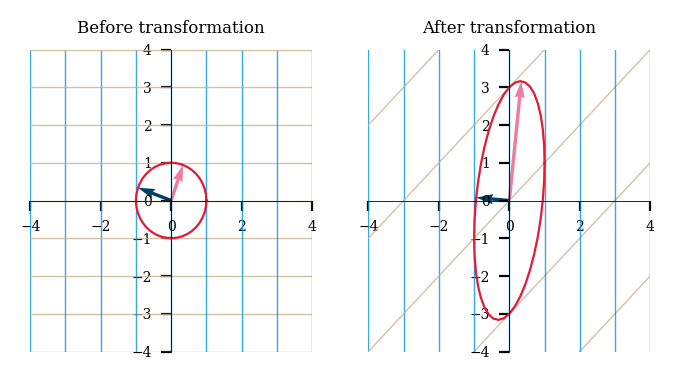

In [6]:
A_inv = numpy.linalg.inv(A)
major_before = A_inv @ major
minor_before = A_inv @ minor
plot_linear_transformation(A, major_before, minor_before, unit_vector=False, unit_circle=True)

We all know that the major and minor axes of an ellipse are orthogonal (perpendicular to each other), however, to our surprise, their corresponding vectors landing on the original unit circle appear to be orthogonal as well. Use inner product to confirm.

In [7]:
print(major.dot(minor))
print(major_before.dot(minor_before))

-0.08055576420695432
1.1102230246251565e-16


If we use $\mathbf{u_1}, \mathbf{u_2}$ to denote the **normalized** `major` and `minor` vectors, use $\mathbf{s_1}, \mathbf{s_2}$ to denote the scaling factor and use $\mathbf{v_1}, \mathbf{v_2}$ to denote `major_before` and `minor_before`, we can express the observation above as:

$$
\begin{align*}
  A \mathbf{v_1} = s_1 \mathbf{u_1} \\
  A \mathbf{v_2} = s_2 \mathbf{u_2}
\end{align*}
$$

Stacking two equations together:

$$
  A \begin{bmatrix}
    \mathbf{v_1} & \mathbf{v_2}
    \end{bmatrix}
    =
    \begin{bmatrix}
    \mathbf{u_1} & \mathbf{u_2}
    \end{bmatrix}
    \begin{bmatrix}
    s_1 & 0 \\
    0 & s_2
    \end{bmatrix}  
$$

Using $V$ to denote $\begin{bmatrix} \mathbf{v_1} & \mathbf{v_2} \end{bmatrix}$, $U$ to denote $\begin{bmatrix} \mathbf{u_1} & \mathbf{u_2} \end{bmatrix}$ and $S$ to denote the diagonal scaling matrix, it becomes:

$$
  A\, V = U\, S
$$

then right-multiply by $V^{-1}$ on both sides:

$$
  A = U\, S\, V^{-1}
$$

Since $\mathbf{v_1}, \mathbf{v_2}$ are orthogonal unit vectors, the matrix $V$ is an orthogonal matrix. (Recall what is an orthogonal matrix from the previous notebook) Thus, $V^T = V^{-1}$, the equation can also be written as:

$$
  A = U\, S\, V^{T}
$$

Starting from discovering the semi-axis of the transformed unit circle, we finally arrive at a neat decomposition of the matrix $A$ - singular value decomposition (SVD). The columns of $U$ are called left singular vectors, the columns of $V$ is called right singular vectors, and the diagonal elements of $S$ are singular values.

Let us build these matrices first.

In [8]:
s1 = numpy.linalg.norm(major)
s2 = numpy.linalg.norm(minor)
S = numpy.diag([s1, s2])
print(S)

[[3.17947611 0.        ]
 [0.         0.94389177]]


In [9]:
u1 = major / s1
u2 = minor / s2
U = numpy.transpose(numpy.vstack((u1,u2)))
print(U)

[[ 0.10653891 -0.99681001]
 [ 0.99430853  0.07981105]]


In [10]:
v1 = major_before
v2 = minor_before
VT = numpy.vstack((v1,v2))
print(VT)

[[ 0.33873792  0.94088077]
 [-0.94088077  0.33873792]]


In [11]:
U @ S @ VT

array([[1., 0.],
       [1., 3.]])

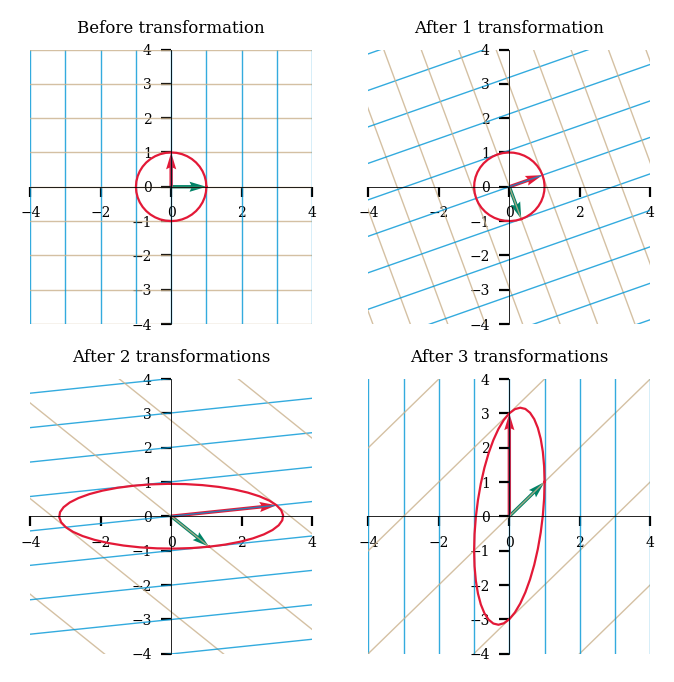

In [13]:
plot_linear_transformations(VT, S, U, unit_circle=True)

In [ ]:
U, S, VT = numpy.linalg.svd(A)